# Plot results of the synthetic test case.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import dask
import pandas as pd
import dask.array as da
import xarray as xr
from climate.utils import load_dataset

from dask.distributed import Client, LocalCluster, wait, progress                             
import diesel as ds                                                             
from diesel.scoring import compute_RE_score, compute_CRPS, compute_energy_score 
from diesel.estimation import localize_covariance 

/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
base_folder = "/storage/homefs/ct19x463/Dev/Climate/Data/"
results_folder = "/storage/homefs/ct19x463/Dev/DIESEL/reporting/toy_example/results_paper/synthetic/"

In [3]:
TOT_ENSEMBLES_NUMBER = 30
(dataset_mean, dataset_members,
    dataset_instrumental, dataset_reference,
    dataset_members_zarr)= load_dataset(
    base_folder, TOT_ENSEMBLES_NUMBER, ignore_members=True)
print("Loading done.")

/storage/homefs/ct19x463/.conda/envs/climate/lib/python3.8/site-packages/xarray/coding/times.py:351: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  sample = dates.ravel()[0]
/storage/homefs/ct19x463/Dev/Climate/climate/utils.py:144: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset_mean['time'] = dataset_mean.indexes['time'].to_datetimeindex()
/storage/homefs/ct19x463/Dev/Climate/climate/utils.py:145: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, '360_day', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataset_members['time'] = dataset_members.ind

Loading done.


In [4]:
cluster = LocalCluster()
client = Client(cluster)

In [5]:
from climate.kalman_filter import EnsembleKalmanFilterScatter
helper_filter = EnsembleKalmanFilterScatter(dataset_mean, dataset_members_zarr, dataset_instrumental, client)

Maximal distance to matched point: 120.54565778878536 km.


## Load Data

In [25]:
rep = 0

ground_truth = np.load(os.path.join(results_folder, "ground_truth_{}.npy".format(rep)))
mean = np.load(os.path.join(results_folder, "mean_{}.npy".format(rep)))
ensemble = np.load(os.path.join(results_folder, "ensemble_{}.npy".format(rep)))

mean_updated_aao_loc = np.load(os.path.join(results_folder, "mean_updated_aao_loc_{}.npy".format(rep))).reshape(-1)
ensemble_updated_aao_loc = np.load(os.path.join(results_folder, "ensemble_updated_aao_loc_{}.npy".format(rep)))

mean_updated_aao_truecov = np.load(os.path.join(results_folder, "mean_updated_aao_truecov_{}.npy".format(rep))).reshape(-1)
ensemble_updated_aao_truecov = np.load(os.path.join(results_folder, "ensemble_updated_aao_truecov_{}.npy".format(rep)))

mean_updated_seq_loc = np.load(os.path.join(results_folder, "mean_updated_seq_loc_{}.npy".format(rep))).reshape(-1)
ensemble_updated_seq_loc = np.load(os.path.join(results_folder, "ensemble_updated_seq_loc_{}.npy".format(rep)))

In [14]:
# Build a square grid with 30^2 elements.
grid = ds.gridding.SquareGrid(n_pts_1d=80)
grid_pts = grid.grid_pts

Builing grid with 0.16384 GB covariance matrix.


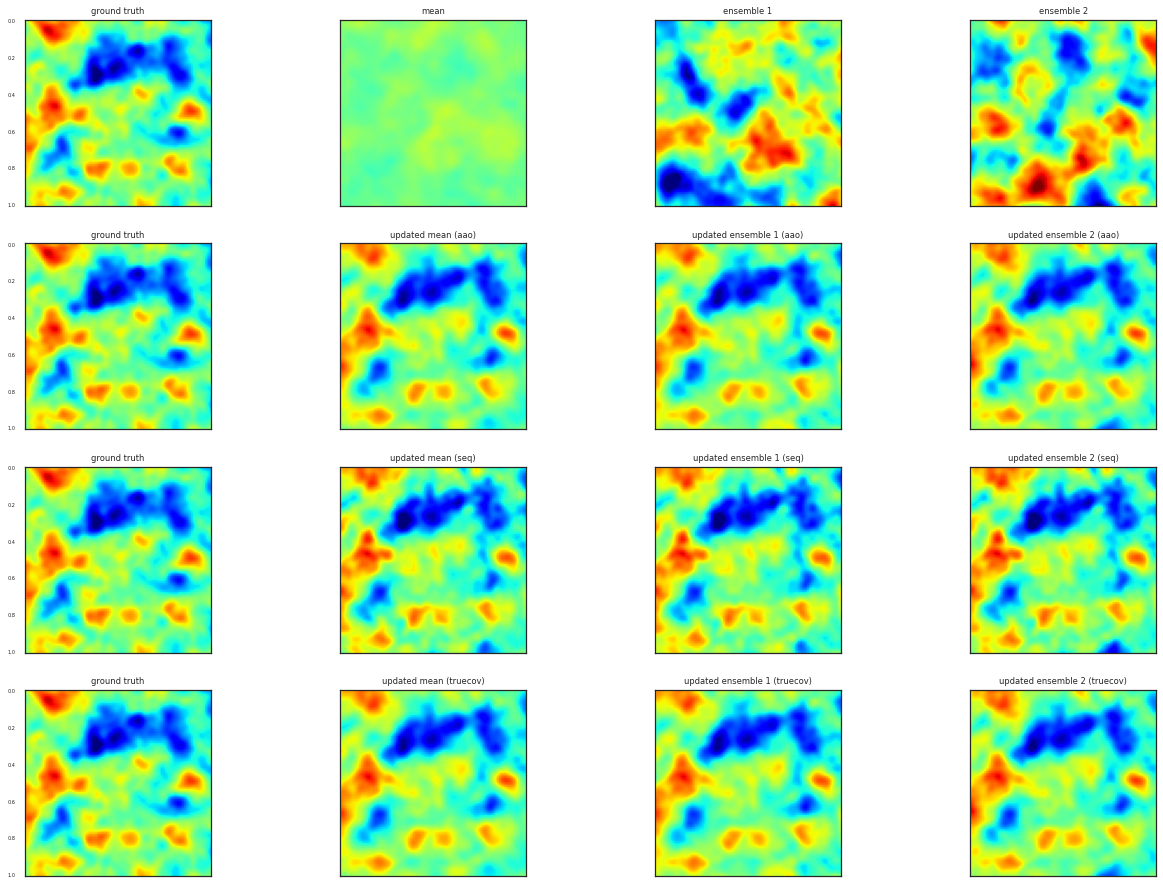

In [26]:
import matplotlib.pyplot as plt

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(4, 4, figsize=(55*cm, 40*cm))

# Prior
grid.plot_vals(ground_truth, axs[0, 0], vmin=-3, vmax=3)
axs[0, 0].title.set_text('ground truth')
axs[0, 0].set_xticks([])

grid.plot_vals(mean, axs[0, 1], vmin=-3, vmax=3)
axs[0, 1].title.set_text('mean')
axs[0, 1].set_xticks([])
axs[0, 1].set_yticks([])

grid.plot_vals(ensemble[0, :], axs[0, 2], vmin=-3, vmax=3)
axs[0, 2].title.set_text('ensemble 1')
axs[0, 2].set_xticks([])
axs[0, 2].set_yticks([])

grid.plot_vals(ensemble[1, :], axs[0, 3], vmin=-3, vmax=3)
axs[0, 3].title.set_text('ensemble 2')
axs[0, 3].set_xticks([])
axs[0, 3].set_yticks([])

# All at once update.
grid.plot_vals(ground_truth, axs[1, 0], vmin=-3, vmax=3)
axs[1, 0].title.set_text('ground truth')
axs[1, 0].set_xticks([])

grid.plot_vals(mean_updated_aao_loc, axs[1, 1], vmin=-3, vmax=3)
axs[1, 1].title.set_text('updated mean (aao)')
axs[1, 1].set_xticks([])
axs[1, 1].set_yticks([])

grid.plot_vals(ensemble_updated_aao_loc[0, :], axs[1, 2], vmin=-3, vmax=3)
axs[1, 2].title.set_text('updated ensemble 1 (aao)')
axs[1, 2].set_xticks([])
axs[1, 2].set_yticks([])

grid.plot_vals(ensemble_updated_aao_loc[1, :], axs[1, 3], vmin=-3, vmax=3)
axs[1, 3].title.set_text('updated ensemble 2 (aao)')
axs[1, 3].set_xticks([])
axs[1, 3].set_yticks([])

# Sequential update.
grid.plot_vals(ground_truth, axs[2, 0], vmin=-3, vmax=3)
axs[2, 0].title.set_text('ground truth')
axs[2, 0].set_xticks([])

grid.plot_vals(mean_updated_seq_loc, axs[2, 1], vmin=-3, vmax=3)
axs[2, 1].title.set_text('updated mean (seq)')
axs[2, 1].set_xticks([])
axs[2, 1].set_yticks([])

grid.plot_vals(ensemble_updated_seq_loc[0, :], axs[2, 2], vmin=-3, vmax=3)
axs[2, 2].title.set_text('updated ensemble 1 (seq)')
axs[2, 2].set_xticks([])
axs[2, 2].set_yticks([])

grid.plot_vals(ensemble_updated_seq_loc[1, :], axs[2, 3], vmin=-3, vmax=3)
axs[2, 3].title.set_text('updated ensemble 2 (seq)')
axs[2, 3].set_xticks([])
axs[2, 3].set_yticks([])

# Truecov update.
grid.plot_vals(ground_truth, axs[3, 0], vmin=-3, vmax=3)
axs[3, 0].title.set_text('ground truth')
axs[3, 0].set_xticks([])

grid.plot_vals(mean_updated_aao_truecov, axs[3, 1], vmin=-3, vmax=3)
axs[3, 1].title.set_text('updated mean (truecov)')
axs[3, 1].set_xticks([])
axs[3, 1].set_yticks([])

grid.plot_vals(ensemble_updated_aao_truecov[0, :], axs[3, 2], vmin=-3, vmax=3)
axs[3, 2].title.set_text('updated ensemble 1 (truecov)')
axs[3, 2].set_xticks([])
axs[3, 2].set_yticks([])

grid.plot_vals(ensemble_updated_aao_truecov[1, :], axs[3, 3], vmin=-3, vmax=3)
axs[3, 3].title.set_text('updated ensemble 2 (truecov)')
axs[3, 3].set_xticks([])
axs[3, 3].set_yticks([])

plt.savefig('test.png', bbox_inches='tight', dpi=200)

## Compute Performance Metrics

In [27]:
# RMSE
print(np.sqrt(np.mean((mean - ground_truth)**2)))
print(np.sqrt(np.mean((mean_updated_aao_loc - ground_truth)**2)))
print(np.sqrt(np.mean((mean_updated_seq_loc - ground_truth)**2)))
print(np.sqrt(np.mean((mean_updated_aao_truecov - ground_truth)**2)))

1.0088945499691586
0.320691133529992
0.38521508272538213
0.3206911335299904


In [29]:
# Energy score.
from diesel.scoring import compute_energy_score

es_prior, _, _ = compute_energy_score(ensemble, ground_truth)
es_aao_loc, _, _ = compute_energy_score(ensemble_updated_aao_loc, ground_truth)
es_seq_loc, _, _ = compute_energy_score(ensemble_updated_seq_loc, ground_truth)
es_aao_truecov, _, _ = compute_energy_score(ensemble_updated_aao_truecov, ground_truth)

print(es_prior)
print(es_aao_loc)
print(es_seq_loc)
print(es_aao_truecov)

57.985565191160006
20.39060018994487
26.96225281029683
20.39060018994474


## Scoring part.

In [6]:
df_scores = pd.read_pickle(os.path.join(results_folder, "scores.pkl"))

In [9]:
df_scores

,RMSE prior,RMSE aao loc,RMSE seq loc,RMSE aao truecov,ES prior,ES aao loc,ES seq loc,ES aao truecov,RE aao loc,RE seq loc,RE aao truecov
0,1.003839,1.381058,1.390683,1.381058,57.454175,17.690572,22.529078,17.690572,"[[0.08435598162180569], [0.08821863889894033],...","[[-0.18440978686630594], [0.019061377023612658...","[[0.08435598162186475], [0.08821863889899861],..."
1,0.889383,1.218430,1.237709,1.218430,51.361824,19.169923,25.183421,19.169923,"[[0.6258902864834754], [0.6338102941019697], [...","[[0.6278546230251383], [0.6297622051384595], [...","[[0.625890286483473], [0.6338102941019618], [0..."


In [12]:
df_scores['RE aao loc'][0].shape

(6400, 1)